In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger



!pip install category_encoders
import category_encoders as ce




# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py --no-check-certificate
from visualization import plot_conf_mat


# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 81kB 3.4MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2020-12-18 10:37:02--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2020-12-18 10:37:02 (114 MB/s) - ‘visualization.py’ saved [13008/13008]



In [5]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'MLTools/'

Mounted at /content/gdrive


In [54]:
sourcehome = pd.read_csv("/content/gdrive/My Drive/MLTools/allhome.csv")
sourceother = pd.read_csv("/content/gdrive/My Drive/MLTools/allnothome.csv")
targethome = pd.read_csv("/content/gdrive/My Drive/MLTools/targethome.csv")

In [55]:
dftargethome.head(n=5)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,...,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.32-216.58.204.110-42367-80-6,192.168.10.32,42367,216.58.204.110,80,6,19/04/2018 04:43:23 PM,13821,5,3,71,83,71,0,14.2,31.752165,83,0,27.666667,47.920072,11142.464370,578.829318,1.974429e+03,1.934825e+03,5279.0,102.0,13821.0,3455.25,4086.838499,8410.0,102.0,5554.0,2777.0,3.514321e+03,5262.0,292.0,0,0,0,0,...,0,83,17.111111,34.086084,1161.861111,1,2,0,2,7,0,0,0,0,19.250000,14.2,27.666667,0,0,0,0,0,0,0,8,0,10,14600,166,1,32,0,0,0,0,1.520000e+15,4.499360e+03,1.520000e+15,1.520000e+15,1
1,192.168.10.32-216.58.204.110-53792-443-6,192.168.10.32,53792,216.58.204.110,443,6,19/04/2018 04:43:04 PM,59640660,2,4,0,55,0,0,0.0,0.000000,55,0,13.750000,27.500000,0.922190,0.100603,1.190000e+07,1.960000e+07,45100000.0,55.0,45100000.0,45100000.00,0.000000,45100000.0,45100000.0,59600000.0,19900000.0,2.300000e+07,45100000.0,55.0,0,0,0,0,...,0,55,7.857143,20.788046,432.142857,1,0,0,1,6,0,0,0,2,9.166667,0.0,13.750000,0,0,0,0,0,0,0,0,0,9,494,208,0,32,0,0,0,0,1.520000e+15,3.110000e+07,1.520000e+15,1.520000e+15,1
2,192.168.10.32-216.58.204.110-53792-443-6,192.168.10.32,53792,216.58.204.110,443,6,19/04/2018 04:44:04 PM,104,2,0,0,0,0,0,0.0,0.000000,0,0,0.000000,0.000000,0.000000,19230.769230,1.040000e+02,0.000000e+00,104.0,104.0,104.0,104.00,0.000000,104.0,104.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,1,0,0,0,2,0,0,0,0,0.000000,0.0,0.000000,0,0,0,0,0,0,1,0,0,0,494,0,0,32,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1
3,192.168.10.32-216.58.215.42-56811-443-6,192.168.10.32,56811,216.58.215.42,443,6,19/04/2018 04:43:04 PM,59656616,2,4,0,55,0,0,0.0,0.000000,55,0,13.750000,27.500000,0.921943,0.100576,1.190000e+07,1.960000e+07,45100000.0,55.0,45100000.0,45100000.00,0.000000,45100000.0,45100000.0,59700000.0,19900000.0,2.300000e+07,45100000.0,55.0,0,0,0,0,...,0,55,7.857143,20.788046,432.142857,1,0,0,1,6,0,0,0,2,9.166667,0.0,13.750000,0,0,0,0,0,0,0,0,0,9,451,183,0,32,0,0,0,0,1.520000e+15,3.110000e+07,1.520000e+15,1.520000e+15,1
4,192.168.10.32-216.58.204.110-42368-80-6,192.168.10.32,42368,216.58.204.110,80,6,19/04/2018 04:44:25 PM,13223,5,3,71,83,71,0,14.2,31.752165,83,0,27.666667,47.920072,11646.373740,605.006428,1.889000e+03,2.318230e+03,6371.0,55.0,13223.0,3305.75,4305.696566,9224.0,100.0,3954.0,1977.0,2.718118e+03,3899.0,55.0,0,0,0,0,...,0,83,17.111111,34.086084,1161.861111,1,2,0,2,7,0,0,0,0,19.250000,14.2,27.666667,0,0,0,0,0,0,0,8,0,10,14600,166,1,32,0,0,0,0,1.520000e+15,4.688463e+03,1.520000e+15,1.520000e+15,1


In [56]:
sourcehome = sourcehome[sourcehome['Protocol'] == 6]
sourceother = sourceother[sourceother['Protocol'] == 6]
targethome = targethome[targethome['Protocol'] == 6]


In [57]:
print(sourcehome.shape)
print(sourceother.shape)
print(targethome.shape)
shuffle(targethome)

(10110, 84)
(16242, 84)
(38608, 84)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,...,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
15381,192.168.10.32-66.102.1.188-56906-5228-6,192.168.10.32,56906,66.102.1.188,5228,6,21/04/2018 03:00:29 PM,90236635,3,3,0,0,0,0,0.00,0.000000,0,0,0.000000,0.000000,0.000000,0.066492,1.800000e+07,2.470000e+07,45100000.0,6967.0,90200000.0,45100000.00,5.078441e+03,45100000.0,45100000.0,90200000.0,45100000.0,5030.357641,45100000.0,45100000.0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0,0,0,0,6,0,0,0,1,0.000000,0.00,0.000000,0,0,0,0,0,0,0,0,0,0,406,179,0,32,0,0,0,0,1.520000e+15,3.680000e+07,1.520000e+15,1.520000e+15,1
100378,192.168.10.32-64.233.184.188-59438-5228-6,192.168.10.32,59438,64.233.184.188,5228,6,25/04/2018 03:46:01 AM,90171579,4,3,25,25,25,0,6.25,12.500000,25,0,8.333333,14.433757,0.554498,0.077630,1.500000e+07,2.330000e+07,45100000.0,2674.0,90200000.0,30100000.00,2.600000e+07,45100000.0,10394.0,90200000.0,45100000.0,49133.314690,45100000.0,45000000.0,1,0,0,0,...,0,25,9.375000,12.938729,167.410714,0,0,0,2,7,0,0,0,0,10.714286,6.25,8.333333,0,0,0,0,0,0,0,3,0,3,406,175,0,32,0,0,0,0,1.520000e+15,3.770000e+07,1.520000e+15,1.520000e+15,1
109701,192.168.10.32-66.102.1.188-48589-5228-6,192.168.10.32,48589,66.102.1.188,5228,6,25/04/2018 10:56:18 PM,90244928,3,3,0,0,0,0,0.00,0.000000,0,0,0.000000,0.000000,0.000000,0.066486,1.800000e+07,2.470000e+07,45100000.0,6941.0,90200000.0,45100000.00,2.448711e+03,45100000.0,45100000.0,90200000.0,45100000.0,2441.639715,45100000.0,45100000.0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0,0,0,0,6,0,0,0,1,0.000000,0.00,0.000000,0,0,0,0,0,0,0,0,0,0,539,179,0,32,0,0,0,0,1.520000e+15,3.680000e+07,1.520000e+15,1.520000e+15,1
22897,192.168.10.32-66.102.1.188-46800-5228-6,192.168.10.32,46800,66.102.1.188,5228,6,22/04/2018 10:17:30 AM,90178980,4,3,26,26,26,0,6.50,13.000000,26,0,8.666667,15.011107,0.576631,0.077623,1.500000e+07,2.330000e+07,45100000.0,5924.0,90200000.0,30100000.00,2.600000e+07,45100000.0,13197.0,90200000.0,45100000.0,43090.380140,45100000.0,45100000.0,1,0,0,0,...,0,26,9.750000,13.456278,181.071429,0,0,0,2,7,0,0,0,0,11.142857,6.50,8.666667,0,0,0,0,0,0,0,3,0,3,406,175,0,32,0,0,0,0,1.520000e+15,3.770000e+07,1.520000e+15,1.520000e+15,1
48972,192.168.10.32-216.58.201.238-46365-443-6,192.168.10.32,46365,216.58.201.238,443,6,25/04/2018 05:02:34 PM,2793,2,1,0,0,0,0,0.00,0.000000,0,0,0.000000,0.000000,0.000000,1074.113856,1.396500e+03,1.748675e+03,2633.0,160.0,160.0,160.00,0.000000e+00,160.0,160.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,1,0,0,0,3,0,0,0,0,0.000000,0.00,0.000000,0,0,0,0,0,0,0,0,0,0,279,179,0,32,0,0,0,0,1.520000e+15,0.000000e+00,1.520000e+15,1.520000e+15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79223,192.168.10.32-216.58.2

In [58]:
targethome=targethome[0:targethome.shape[0]//10]

In [59]:
print(sourcehome.shape)
print(sourceother.shape)
print(targethome.shape)

(10110, 84)
(16242, 84)
(3860, 84)


In [60]:
sourcedata=sourcehome.append(sourceother)
targetdata=targethome.append(sourceother)
print(sourcedata.shape)
print(targetdata.shape)

(26352, 84)
(20102, 84)


In [61]:
sourcedata["Flow Duration"] = np.log((sourcedata["Flow Duration"] + 0.1).astype(float)) 

In [62]:
sourcedata.drop(['Flow ID','Dst IP','Src IP','Timestamp','Dst Port','Src Port','Protocol'], axis=1, inplace=True)
##Verify that the dimension has dropped by 1 and therefore label has been removed
sourcedata.shape

(26352, 77)

In [63]:
targetdata["Flow Duration"] = np.log((targetdata["Flow Duration"] + 0.1).astype(float))

In [64]:
targetdata.drop(['Flow ID','Dst IP','Src IP','Timestamp','Dst Port','Src Port','Protocol'], axis=1, inplace=True)
##Verify that the dimension has dropped by 1 and therefore label has been removed
print(targetdata.shape)

(20102, 77)


In [136]:
X = sourcedata.drop(['Label'], axis=1)
Xnew = targetdata.drop(['Label'], axis=1)

In [96]:
type(X)

pandas.core.frame.DataFrame

In [137]:
y = sourcedata['Label']
ynew = targetdata['Label']

In [138]:
y = pd.DataFrame(y)
ynew = pd.DataFrame(ynew)

In [101]:
type(y)

pandas.core.frame.DataFrame

In [102]:
X, y = shuffle(X, y)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [94]:
type(y_train)

pandas.core.series.Series

In [105]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('X_train scaled\n', X_train[0:6, 2] )

X_train scaled
 [0.00027382 0.00164294 0.00191676 0.01341731 0.00684556 0.00136911]


In [106]:
# To know more: 
#       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np.random.seed(6)
tf.random.set_seed(4)

In [107]:
sample_size = X_train.shape[1]
print('The sample size is ', sample_size, 
      ', which should correspond to the number of features')

The sample size is  76 , which should correspond to the number of features


In [108]:
learn_rate = 0.01

In [110]:
def build_model():
  model = Sequential([
    Dense(200, input_dim=sample_size, activation='relu' ),
    Dense(50, activation='relu' ),
    Dense(30, activation='relu' ),
    Dense(15, activation='relu' ),
    Dense(8, activation='relu' ),
    Dense(1, activation="sigmoid")
  ])



  model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.SGD(lr=learn_rate) ,
              metrics=['accuracy'])

  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 200)               15400     
_________________________________________________________________
dense_12 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_13 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_14 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 128       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 27,582
Trainable params: 27,582
Non-trainable params: 0
__________________________________________________

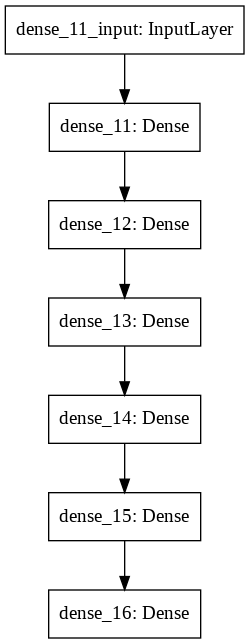

In [111]:
model = build_model()
model.summary()
plot_model(model)

In [112]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
330/330 [==============================] - 2s 3ms/step - loss: 0.6759 - accuracy: 0.5976 - val_loss: 0.6534 - val_accuracy: 0.5967
Epoch 2/10
330/330 [==============================] - 1s 2ms/step - loss: 0.6363 - accuracy: 0.6222 - val_loss: 0.5974 - val_accuracy: 0.6259
Epoch 3/10
330/330 [==============================] - 1s 2ms/step - loss: 0.5673 - accuracy: 0.7318 - val_loss: 0.4783 - val_accuracy: 0.7986
Epoch 4/10
330/330 [==============================] - 1s 2ms/step - loss: 0.4622 - accuracy: 0.7928 - val_loss: 0.4075 - val_accuracy: 0.8005
Epoch 5/10
330/330 [==============================] - 1s 2ms/step - loss: 0.4115 - accuracy: 0.7955 - val_loss: 0.3761 - val_accuracy: 0.8137
Epoch 6/10
330/330 [==============================] - 1s 2ms/step - loss: 0.3660 - accuracy: 0.8221 - val_loss: 0.3622 - val_accuracy: 0.8407
Epoch 7/10
330/330 [==============================] - 1s 2ms/step - loss: 0.3655 - accuracy: 0.8268 - val_loss: 0.3652 - val_accuracy: 0.8392
Epoch 

In [113]:
def train_model(nn_file, X_tr, y_tr, epochs, overwrite=False):
  """
  nn_file:  Before training, the model contained in this file will be loaded
            After training, the resulting model will be written in this file

  
  overwrite: If true, the model will be built and trained from scratch
  """
  
  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/



  if overwrite==True:
    os.remove(nn_file)
    os.remove(nn_file+'.csv')


  if not isfile(nn_file):
    model = build_model()
  else:
    model = load_model(nn_file)

  history = model.fit(X_tr, y_tr, epochs=epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb], 
                      validation_split=0.2 )

  return model

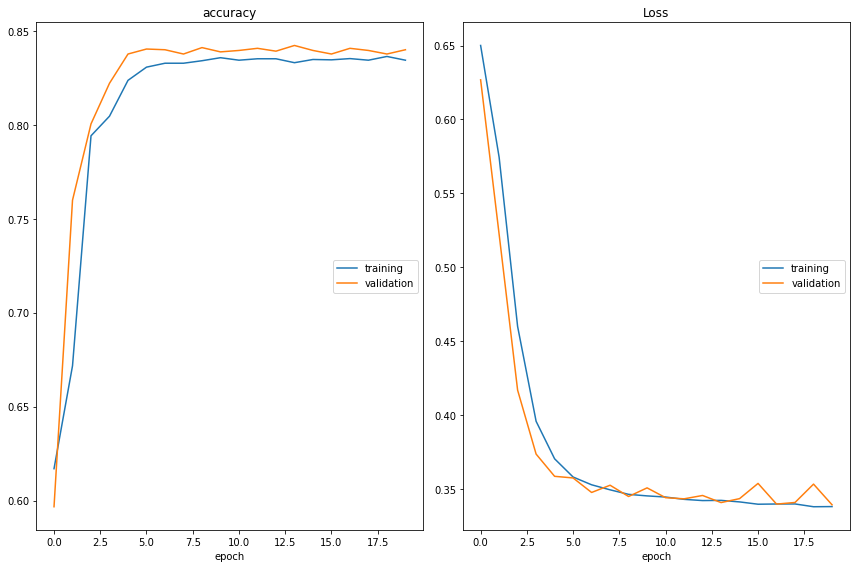

accuracy
	training         	 (min:    0.617, max:    0.836, cur:    0.834)
	validation       	 (min:    0.597, max:    0.842, cur:    0.840)
Loss
	training         	 (min:    0.338, max:    0.650, cur:    0.338)
	validation       	 (min:    0.339, max:    0.627, cur:    0.339)


In [114]:
nn_file = my_path + 'nn1.h5'

model = train_model(nn_file, X_train, y_train, epochs=20)

In [115]:
pd.read_csv(nn_file+'.csv').head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.616983,0.650062,0.596738,0.626815
1,1,0.671727,0.574462,0.759863,0.522323
2,2,0.794118,0.459896,0.800455,0.416792
3,3,0.804554,0.395698,0.822079,0.373511
4,4,0.823624,0.370320,0.837633,0.358462


In [116]:
def plot_train_hist(csv_hist_file):
  hist_df = pd.read_csv(csv_hist_file)
  hist_df[['accuracy', 'loss', 'val_accuracy', 'val_loss']].plot()

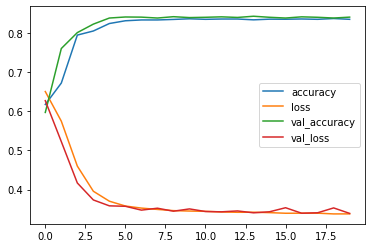

In [117]:
plot_train_hist(nn_file+'.csv')

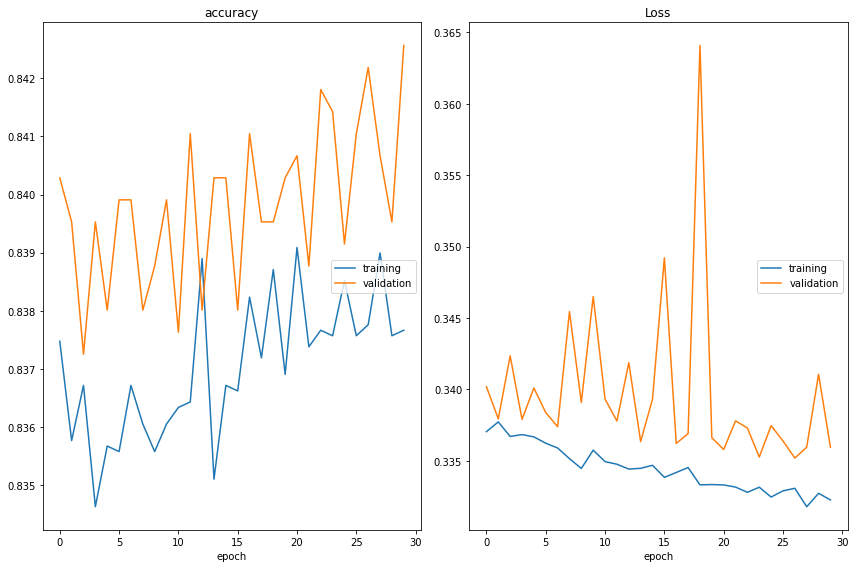

accuracy
	training         	 (min:    0.835, max:    0.839, cur:    0.838)
	validation       	 (min:    0.837, max:    0.843, cur:    0.843)
Loss
	training         	 (min:    0.332, max:    0.338, cur:    0.332)
	validation       	 (min:    0.335, max:    0.364, cur:    0.336)


In [118]:
model = train_model(nn_file, X_train, y_train, epochs=30)

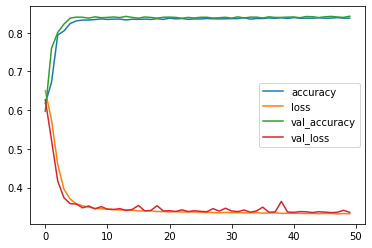

In [119]:

plot_train_hist(nn_file+'.csv')

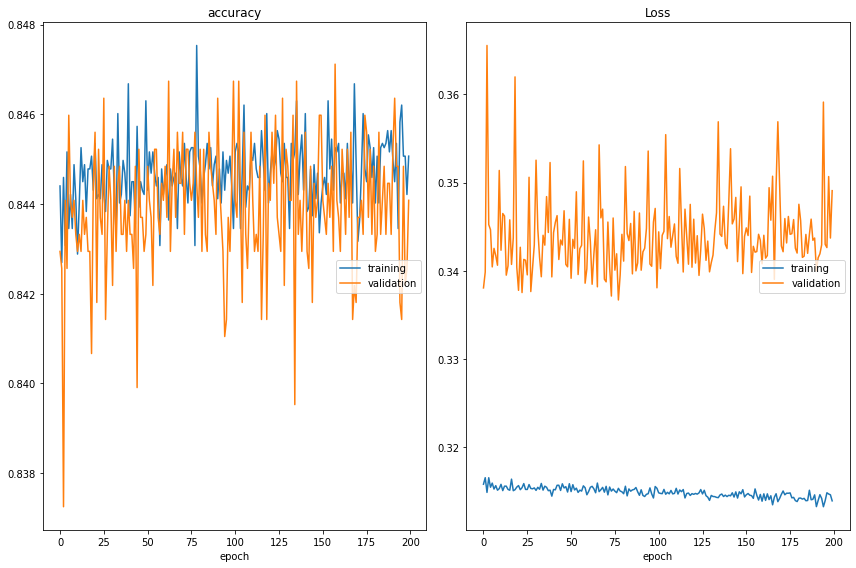

accuracy
	training         	 (min:    0.843, max:    0.848, cur:    0.845)
	validation       	 (min:    0.837, max:    0.847, cur:    0.844)
Loss
	training         	 (min:    0.313, max:    0.317, cur:    0.314)
	validation       	 (min:    0.337, max:    0.366, cur:    0.349)


In [121]:
model = train_model(nn_file, X_train, y_train, epochs=200)

In [122]:
model = load_model(nn_file)                                                                                              

In [123]:
y_proba = model.predict(X_test)
print( 'y_proba\n', y_proba)

pred_label = model.predict_classes(X_test)
print( 'pred_label\n', pred_label )

y_proba
 [[2.4902150e-07]
 [5.1413327e-01]
 [6.9317871e-01]
 ...
 [2.4429387e-06]
 [4.1368043e-08]
 [1.5645941e-07]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


pred_label
 [[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [124]:
y_test.values

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [134]:
true_label = y_test.values
true_label

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

Normalized confusion matrix
[[0.7627867 0.2372133]
 [0.0479793 0.9520207]]


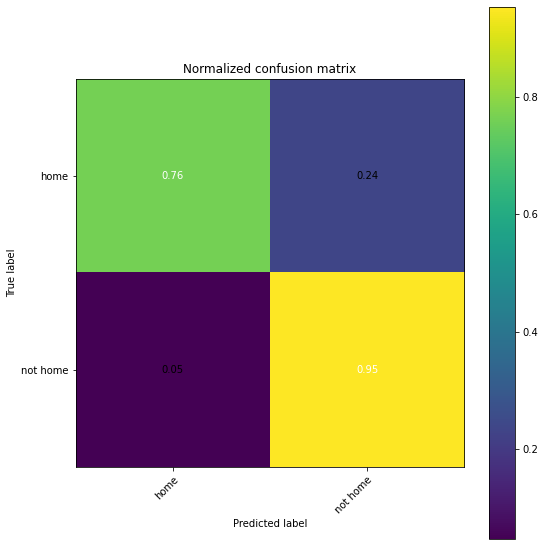

In [135]:
class_names=["home","not home"]
plot_conf_mat(true_label, pred_label, np.array(class_names))

##Evaluate on target home data

In [139]:
model = load_model(nn_file)

In [140]:
Xnew, ynew = shuffle(Xnew, ynew)

In [141]:
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(Xnew, ynew, test_size=0.5)

In [142]:
scaler = MinMaxScaler()
scaler.fit(X_train)

Xnew_train = scaler.transform(Xnew_train)
Xnew_test = scaler.transform(Xnew_test)

print('Xnew_train scaled\n', Xnew_train[0:6, 2] )

X_train scaled
 [2. 0. 5. 4. 4. 4.]


In [143]:
ynew_proba = model.predict(Xnew_test)
print( 'y_proba\n', ynew_proba)

prednew_label = model.predict_classes(Xnew_test)
print( 'pred_label\n', prednew_label )

y_proba
 [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


pred_label
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [144]:
truenew_label = ynew_test.values
truenew_label

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

Normalized confusion matrix
[[0.93662491 0.06337509]
 [0.99580932 0.00419068]]


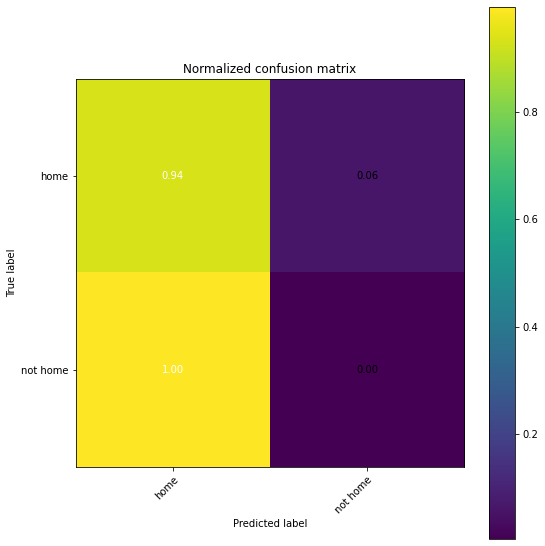

In [146]:
class_names=["home","not home"]
plot_conf_mat(truenew_label, prednew_label, np.array(class_names))

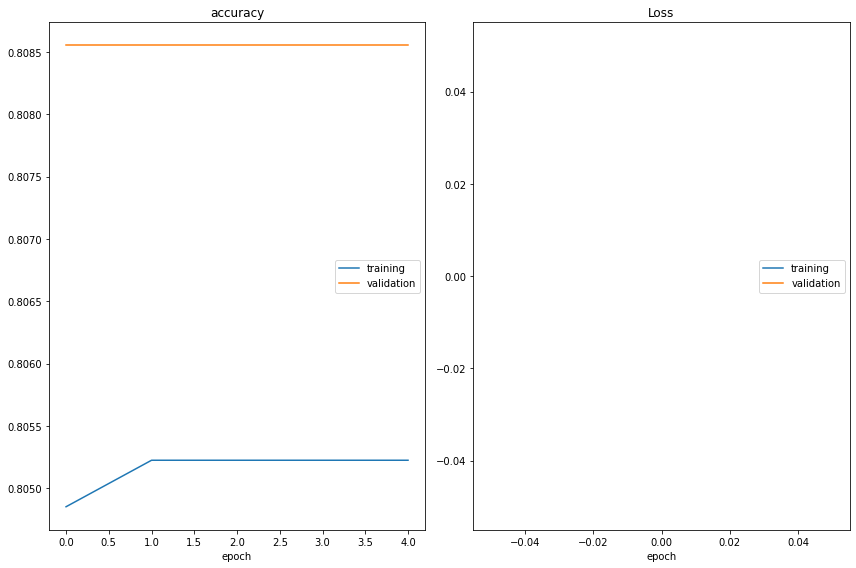

accuracy
	training         	 (min:    0.805, max:    0.805, cur:    0.805)
	validation       	 (min:    0.809, max:    0.809, cur:    0.809)
Loss
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)


In [147]:
model = train_model(nn_file, Xnew_train, ynew_train, epochs=5)